# Red Wine Quality

### Background & short intro

--for blog post: Last year, as part of the EE3-23 Machine Learning coursework, we were asked to analyse and apply various ML algorithms to the Red & Wine Quality Dataset (insert link to the official UCI dataset). Yesterday, I decided to revisit my work, this time focusing only on the Red Wine Dataset (insert link to Kaggle?). You can however still find my old submission for both wine types combined on this repo (insert link to my repo). --

--Note: As usual, you can also follow the content on a Jupyter notebook, within my Github repository (insert links after google search console has indexed the blog post!) --

Our motivation is to study and implement multiple linear and non-linear machine learning algorithms and evaluate their performance.

The chosen dataset consists of red wine samples from the north of Portugal. Each instance is composed of 12 variables: 11 physicochemical properties and a quality score which ranges from 1 (lowest) to 10 (highest).

We will investigate those predictors which, taking the 11 physicochemical properties as inputs, can predict the wine quality with the smallest error possible.

### Importing libraries

In [20]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

### Initial dataset observations

In [2]:
df = pd.read_csv('./winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Our dataset consists of 1599 wine instances, and does not seem to have any missing value

In [4]:
df['quality'].sort_values().unique()

array([3, 4, 5, 6, 7, 8], dtype=int64)

There are only 6 unique values for quality scores in our dataset. They range from 3 to 8.

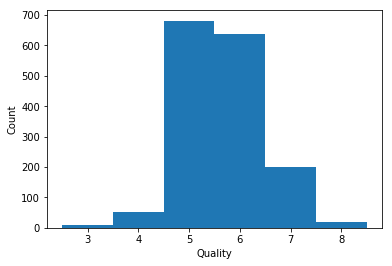

In [5]:
def plot_wine_quality_histogram(quality):
    unique_vals = df['quality'].sort_values().unique()
    plt.xlabel("Quality")
    plt.ylabel("Count")
    plt.hist(quality.values, bins=np.append(unique_vals, 9), align='left')
plot_wine_quality_histogram(df['quality'])

Looks like the distribution of quality scores is heavily centred around 5 and 6. This inbalance is likely to pose a challenge to our learning models, since most algorithms will tend to centre their predictions around 5 and 6, making the rest of the scores harder to predict.

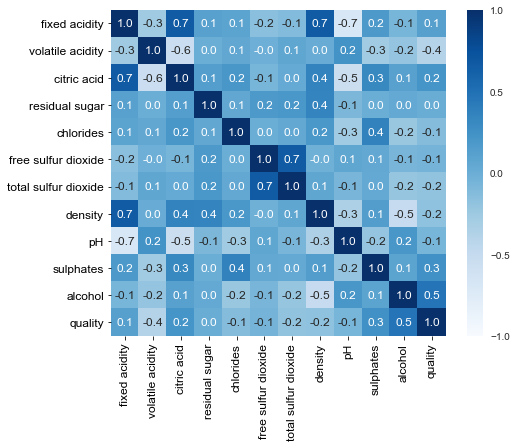

In [8]:
def plot_features_correlation(df):
    plt.figure(figsize=(7.5,6))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.set(font_scale=1)
    corr_mat = df.corr()
    ax = sns.heatmap(data=corr_mat, annot=True, fmt='0.1f', vmin=-1.0, vmax=1.0, center=0.0, xticklabels=corr_mat.columns, yticklabels=corr_mat.columns, cmap="Blues")
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
plot_features_correlation(df)

Plotting the correlation between all the given variables shows that the most positively correlated with quality is alcohol. Thus, alcohol is likely to have the biggest effect when predicting quality.

### Data preprocessing

We first split our data into training (80%) and test (20%) sets.

In [10]:
y = df.quality
X = df.drop('quality', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Since our dataset is quite sparse and has attributes of varying scales, it is important to __standardize our data__ (instead of applying other popular data preprocessing techniques such as Min-Max scaling or a transformation to unit norm)
To achieve this, we standardise the training data to have __zero mean__ and __one standard deviation__. We then use these training parameters to scale our test data, which is the correct way of performing these kinds of tasks (for more info, check out this article http://sebastianraschka.com/Articles/2014_about_feature_scaling.html)

In [11]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Loss function and metrics

In our models, we would like to capture the idea that, for a wine of quality 5, an incorrect prediction of 2 is inherently somewhat worse than an (also incorrect) prediction of 4.

For this purpose, we will choose a loss function equal to the squared error. This is a widely used loss function in regression problems. The idea behind squaring the error is that negative values do not cancel positive ones.

Throughout the rest of this study, we will make use of 2 different metrics in order to properly interpret and compare our results: __accuracy (%)__ and __mean squared error (MSE)__. Accuracy is a widely used metric in this field for performance benchmarking, hence why we will be reporting it. However, since this dataset does not have an equal number of instances of each quality score, it loses relevance and fails to capture the whole picture. To overcome this, we will also be using the mean squared error: this will provide us with extra information about the quality of the predictions (distance to the correct label), which the accuracy metric fails to provide.

When looking at accuracy, higher is better. When looking at MSE, it will be the opposite.

### Initial approaches: Regression

In this section we try to solve the problem using regression. This is a good starting point, since our quality attribute is _discrete numeric_ (ideal for regressions).

#### Baseline regressor

Before even attempting a simple linear regression, it is important (and good practice) to consider the very most baseline predictor: one that always predicts the output to be the same number.

In this case, we choose this to be the mean of the quality attribute (of the training dataset).

In [12]:
def scores_results(y_train, y_test, y_pred_train, y_pred_test):
    #this function will provide us with accuracy and mse scores for training and test sets
    y_pred_train_round = np.round(y_pred_train)
    y_pred_test_round = np.round(y_pred_test)
    accuracy = [accuracy_score(y_train, y_pred_train_round), accuracy_score(y_test, y_pred_test_round)]
    mse_with_rounding = [mean_squared_error(y_train, y_pred_train_round), mean_squared_error(y_test, y_pred_test_round)]
    results = pd.DataFrame(list(zip(accuracy, mse_with_rounding)), columns = ['accuracy score', 'mse (after rounding)'], index = ['train', 'test'])
    return results

def baseline(X_train_scaled, X_test_scaled, y_train, y_test):
    #dummy regressor which always predicts the mean of the dataset
    from sklearn.dummy import DummyRegressor
    baseline = DummyRegressor(strategy='mean')
    baseline.fit(X_train_scaled, y_train)
    y_pred_train = baseline.predict(X_train_scaled)
    y_pred_test = baseline.predict(X_test_scaled)
    return scores_results(y_train, y_test, y_pred_train, y_pred_test)

baseline(X_train_scaled, X_test_scaled, y_train, y_test)

,accuracy score,mse (after rounding)
train,0.398749,0.784988
test,0.400000,0.781250


Interestingly, despite there being 6 classes (the quality scores range from 3 to 8), this dummy algorithm achieves a surprisingly high accuracy of 40%.

This is, again, due to the fact that most wine instances in our dataset (more than half of them, in fact) have a quality of 5 or 6, as shown earlier.

This is our baseline model. The next algorithms we try should be __consistently outperforming it__.

#### Linear regression

Our first serious approach is to implement a classic linear regression:

In [13]:
def linear_reg(X_train_scaled, X_test_scaled, y_train, y_test):
    # basic linear regression
    from sklearn.linear_model import LinearRegression
    lm = LinearRegression()
    lm.fit(X_train_scaled, y_train)
    y_pred_train = lm.predict(X_train_scaled)
    y_pred_test = lm.predict(X_test_scaled)
    global metrics_lr #store this for a later comparison between different methods
    metrics_lr = [accuracy_score(y_test, np.round(y_pred_test)), mean_squared_error(y_test, y_pred_test), r2_score(y_test, y_pred_test)]
    return scores_results(y_train, y_test, y_pred_train, y_pred_test)
linear_reg(X_train_scaled, X_test_scaled, y_train, y_test)

,accuracy score,mse (after rounding)
train,0.587959,0.505082
test,0.628125,0.462500


With an accuracy of over 62%, this basic linear regression already improves our baseline of 40% by quite a significant amount. Let's keep exploring this path.

#### Adding regularisation

It is usually a good idea to introduce some regularisation (penalty) in linear regressions, particularly to avoid overfitting. We will consider 3 different popular regularisation methods: __Lasso (L1)__, __Ridge (L2)__ and __Elastic Net
(L1 and L2)__.

In theory, we expect the Ridge regression to provide better results than Lasso, since this dataset only has 11 features, and therefore the main advantage of Lasso, its feature selection property, will not really come into play.

We use 10-fold cross-validation to select the best parameter lambda for each of the three regressions.

In [14]:
def lasso_reg(X_train_scaled, X_test_scaled, y_train, y_test):
    from sklearn.linear_model import LassoCV
    n_alphas = 5000
    alpha_vals = np.logspace(-6, 0, n_alphas)
    lr = LassoCV(alphas=alpha_vals, cv=10, random_state=0)
    lr.fit(X_train_scaled, y_train)
    y_pred_train = lr.predict(X_train_scaled)
    y_pred_test = lr.predict(X_test_scaled)
    metrics_lasso = [accuracy_score(y_test, np.round(y_pred_test)), mean_squared_error(y_test, y_pred_test), r2_score(y_test, y_pred_test)]
    return metrics_lasso
def elastic_net_reg(X_train_scaled, X_test_scaled, y_train, y_test):
    from sklearn.linear_model import ElasticNetCV
    n_alphas = 300
    l1_ratio = [.1, .3, .5, .7, .9]
    rr = ElasticNetCV(n_alphas=n_alphas, l1_ratio=l1_ratio, cv=10, random_state=0)
    rr.fit(X_train_scaled, y_train)
    y_pred_train = rr.predict(X_train_scaled)
    y_pred_test = rr.predict(X_test_scaled)
    metrics_en = [accuracy_score(y_test, np.round(y_pred_test)), mean_squared_error(y_test, y_pred_test), r2_score(y_test, y_pred_test)]
    return metrics_en
def ridge_reg(X_train_scaled, X_test_scaled, y_train, y_test):
    from sklearn.linear_model import RidgeCV
    n_alphas = 100
    alpha_vals = np.logspace(-1, 3, n_alphas)
    rr = RidgeCV(alphas=alpha_vals, cv=10)
    rr.fit(X_train_scaled, y_train)
    y_pred_train = rr.predict(X_train_scaled)
    y_pred_test = rr.predict(X_test_scaled)
    metrics_ridge = [accuracy_score(y_test, np.round(y_pred_test)), mean_squared_error(y_test, y_pred_test), r2_score(y_test, y_pred_test)]
    return metrics_ridge

metrics_lasso = lasso_reg(X_train_scaled, X_test_scaled, y_train, y_test)
metrics_en = elastic_net_reg(X_train_scaled, X_test_scaled, y_train, y_test)
metrics_ridge = ridge_reg(X_train_scaled, X_test_scaled, y_train, y_test)
finalscores = pd.DataFrame(list(zip(metrics_lr, metrics_lasso, metrics_en, metrics_ridge)), columns = ['lr', 'lasso', 'el net', 'ridge'], index = ['acc','mse','r2'])
finalscores

,lr,lasso,el net,ridge
acc,0.628125,0.628125,0.628125,0.625000
mse,0.401036,0.400986,0.399993,0.400429
r2,0.378502,0.378580,0.380119,0.379442


Interestingly, adding regularisation did not really outperform our basic linear regression. This could be because it never suffered too much from overfitting in the first place.
We can confirm however, that Ridge does indeed (marginally) outperform Lasso, as expected, and that Elastic net is slightly
the best of all. This is due to the fact that it combines the advantages of both L1 and L2 penalty functions.

#### Feature Transformation

Before completely moving away from linear regression algorithms, it could be interesting to try transforming the features with different polynomials.

Recall that a transformation of a set of 2 features $(X_1, X_2)$ to second-order will yield a new set of features $(1, X_1, X_2, X_1X_2, X_1^2, X_2^2)$.

In our case, since we have 11 features, a transformation of degree 2 will yield __78 features__, and one of degree 3, __170 features__.

In [15]:
from sklearn.preprocessing import PolynomialFeatures
X_deg2 = PolynomialFeatures(degree=2).fit_transform(X) #this has now 78 feautures
X_deg3 = PolynomialFeatures(degree=3).fit_transform(X) #this has now 170 features

X_train_deg2, X_test_deg2, y_train_deg2, y_test_deg2 = train_test_split(X_deg2, y, test_size=0.2, random_state=0, stratify=y)
X_train_deg3, X_test_deg3, y_train_deg3, y_test_deg3 = train_test_split(X_deg3, y, test_size=0.2, random_state=0, stratify=y)

scaler_deg2 = preprocessing.StandardScaler().fit(X_train_deg2)
scaler_deg3 = preprocessing.StandardScaler().fit(X_train_deg3)

X_train_scaled_deg2 = scaler_deg2.transform(X_train_deg2)
X_train_scaled_deg3 = scaler_deg3.transform(X_train_deg3)

X_test_scaled_deg2 = scaler_deg2.transform(X_test_deg2)
X_test_scaled_deg3 = scaler_deg3.transform(X_test_deg3)

We run the same regressions as in the previous section (same 10-fold cross-validation, etc.) but this time with the new sets of features:

In [17]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning) #this is just to disable some anoying warnings that sklearn forces to always come up

linear_reg(X_train_scaled_deg2, X_test_scaled_deg2, y_train_deg2, y_test_deg2)
metrics_lasso = lasso_reg(X_train_scaled_deg2, X_test_scaled_deg2, y_train_deg2, y_test_deg2)
metrics_en = elastic_net_reg(X_train_scaled_deg2, X_test_scaled_deg2, y_train_deg2, y_test_deg2)
metrics_ridge = ridge_reg(X_train_scaled_deg2, X_test_scaled_deg2, y_train_deg2, y_test_deg2)

finalscores = pd.DataFrame(list(zip(metrics_lr, metrics_lasso, metrics_en, metrics_ridge)), columns = ['lr', 'lasso', 'el net', 'ridge'], index = ['acc','mse','r2'])
finalscores

,lr,lasso,el net,ridge
acc,0.606250,0.637500,0.650000,0.650000
mse,0.377009,0.383451,0.384568,0.384121
r2,0.415738,0.405754,0.404024,0.404717


In [23]:
linear_reg(X_train_scaled_deg3, X_test_scaled_deg3, y_train_deg3, y_test_deg3)
metrics_lasso = lasso_reg(X_train_scaled_deg3, X_test_scaled_deg3, y_train_deg3, y_test_deg3)
metrics_en = elastic_net_reg(X_train_scaled_deg3, X_test_scaled_deg3, y_train_deg3, y_test_deg3)
metrics_ridge = ridge_reg(X_train_scaled_deg3, X_test_scaled_deg3, y_train_deg3, y_test_deg3)

finalscores = pd.DataFrame(list(zip(metrics_lr, metrics_lasso, metrics_en, metrics_ridge)), columns = ['lr', 'lasso', 'el net', 'ridge'], index = ['acc','mse','r2'])
finalscores

,lr,lasso,el net,ridge
acc,0.565625,0.643750,0.637500,0.643750
mse,1.711643,0.389118,0.387027,0.384262
r2,-1.652586,0.396971,0.400212,0.404498


Interesting! Looks like we finally see an increase in performance. This was somehow expected, since 11 features was quite a low number to begin with, and 78 (and 170) features have the potential of giving us much more information. There is however something slightly controversial: when using a degree of 2, the non-regularised model surprisingly outperforms the regularised ones, but this is not the case when using a degree of 3. A possible explanation could be that the simple regression using degree 2 features does not suffer from overfitting yet (and therefore regularisation is neither necessary nor advised), while when using degree 3 features, the simple model actually begins to overfit, and regularisation starts doing a better job. This would also explain the poor performance of the non-regularised linear regression on the set with degree 3 features.

Another interesting observation is that Ridge is the best of the regularised regressions in both degree 2 and 3. This is probably because, as we saw earlier, there is some multicollinearity between several of the features. Applying a polynomial transformation does not change this (in fact, if anything, it would worsen it), and one of the main advantages of the L2 penalty is, precisely, that it helps address multicollinearity.

### Support Vector Machines (SVM)

A _Support Vector Machine (SVM)_ aims to maximize the margin between data points and a separating hyperplane. This hyperplane is defined by the so-called Support Vectors. SVMs use _kernels_ to transform the original data into a new space. Some of the most widely used kernels are: _linear_, _polynomials_, _RBF (Radial Based Function)_ and _sigmoid_.

The choice of kernel depends on the dataset, however, generally, RBF tends to outperform the others, and, in fact, this also seems to be the case for this dataset (proof not showed here due to space considerations, so you'll have to trust my word).

The __RBF kernel__ is a nonlinear and flexible one, which might be _prone to overfitting_. To avoid this problem, we need to carefully finetune its hyperparameters, which are $\gamma$, $\varepsilon$ and C. We do this using 10-fold cross-validation.

$\gamma$ is the free parameter of the Gaussian RBF function. A lower $\gamma$ helps to fight overfitting (by increasing the bias and decreasing the variance).

$\varepsilon$, despite controlling something different (the size of the tube within which we tolerate prediction errors), ends up having a similar influence.

Finally, C is the cost parameter, which controls the trade-off between the model complexity and the amount up to which deviations greater than $\varepsilon$ can be tolerated.

In [22]:
def svm_reg(X_train_scaled, X_test_scaled, y_train, y_test):
    from sklearn.svm import SVR
    parameters = [{'C': [0.1, 1, 10],
                   'epsilon': [0.01, 0.1],
                    'gamma': [0.01, 0.1, 0.3, 0.5, 1]}]
    clf2 = SVR(kernel = 'rbf')
    clf = GridSearchCV(clf2, parameters, cv=10)
    clf.fit(X_train_scaled, y_train)
    y_pred_train = clf.predict(X_train_scaled)
    y_pred_test = clf.predict(X_test_scaled)
    best_parameters = clf.best_params_
    print ('best parameters:', best_parameters)
    return scores_results(y_train, y_test, y_pred_train, y_pred_test)
svm_reg(X_train_scaled, X_test_scaled, y_train, y_test)

best parameters: {'C': 1, 'epsilon': 0.01, 'gamma': 0.1}


,accuracy score,mse (after rounding)
train,0.696638,0.366693
test,0.646875,0.465625


These results clearly outperform all of the other methods we have tried so far. It seems like the RBF kernel does indeed quite a good job in separating our data. It is interesting to see how the results for the training data are significantly better from those of the test data. This means that our model is suffering from _overfitting_, even after our hyperparameter tuning.

### Neural Networks

Neural Networks are booming in the field of Machine Learning and Pattern Recognition. In this section we will be fitting a Multi-Layer Perceptron Neural Network, which performs training using the _backpropagation algoritm_.

Once again, to avoid overfitting, we will perform (10-fold) cross-validation over three hyperparameters: the number of hidden (fully-connected) layers, alpha (the L2 penalty used for regularisation) and the activation function at the end of each neuron.

In [21]:
def nn_reg(X_train_scaled, X_test_scaled, y_train, y_test):
    from sklearn.neural_network import MLPRegressor
    parameters = [{'hidden_layer_sizes': [3, 5, 10, 100],
                   'alpha': [0.01, 1, 10, 100],
                   'activation': ['relu','logistic','tanh', 'identity']}]
    nn = MLPRegressor(solver='lbfgs', random_state=0)
    nn = GridSearchCV(nn, parameters, cv = 10)
    nn.fit(X_train_scaled, y_train)
    y_pred_train = nn.predict(X_train_scaled)
    y_pred_test = nn.predict(X_test_scaled)
    best_parameters = nn.best_params_
    print ('best parameters:', best_parameters)
    return scores_results(y_train, y_test, y_pred_train, y_pred_test)
nn_reg(X_train_scaled, X_test_scaled, y_train, y_test)

best parameters: {'activation': 'tanh', 'alpha': 10, 'hidden_layer_sizes': 10}


,accuracy score,mse (after rounding)
train,0.619234,0.443315
test,0.653125,0.421875


The solver used for weight optimization is _lbfgs_, an optimizer in the family of quasi-Newton methods which tends to have one of the best performances.

This set-up demonstrates a very competitive performance, even ourperforming that of the SVM. What is more, it does not seem to be suffering from _overfitting_ at all (in fact, if anything, it would be suffering from _underfitting_!). This indicates that a deeper focus on this NN approach could potentially through even better results. I welcome feedback on how to take this model from here and improve it!

## Discussion of results

Overall, the MLP Neural Network performed the best, and thus becomes our preferred method for implementation. However, the SVM method also left a good impression, and it could be interesting to see future work on it, for example regarding using other types of Neural Networks different than the MLP.

The results, in general, however, are not very encouraging, especially when we look at accuracy. We only managed to bring it up from 40.00% (baseline case) to 65.31% (using an RBF kernel). We suspect that this might be a consequence of the dataset being particularly sensitive to subjectiveness: the fact that the quality score is formulated by humans, even if these are experts in their field, seems to suggest that __there might not be a clear correlation__ between what society considers to be a _good wine_ and its _physicochemical properties_.
